# **Data visualisation**

## Objectives

* Creating data visualisation that can be displayed to the customer/user of the service

## Inputs
### Normal
* inputs/mildew_dataset/cherry-leaves/train
* inputs/mildew_dataset/cherry-leaves/test
* inputs/mildew_dataset/cherry-leaves/validation

### Gray scale
* inputs/mildew_dataset/cherry-leaves/gray-scale/gray-test
* inputs/mildew_dataset/cherry-leaves/gray-scale/gray-train
* inputs/mildew_dataset/cherry-leaves/gray-scale/gray-validation

## Outputs

* Image shape embeddings pickle file
* Mean and variability of images per label plot
* plot to distinguise contrast between mildew conatined leaf and healthjy leaf 





---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

### Import necessary packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection'

---

## set input directory

Setting the input directory to a variable named my_data_dir + my_data_dir_gray

In [8]:
my_data_dir = "inputs/mildew_dataset/cherry-leaves"
train_path = my_data_dir + "/" + "train"
test_path = my_data_dir + "/" + "test"
val_path = my_data_dir + "/" + "validation"

my_data_dir_gray = "inputs/mildew_dataset/gray_images"
train_path_gray = my_data_dir_gray + "/" + "train"
test_path_gray = my_data_dir_gray + "/" + "test"
val_path_gray = my_data_dir_gray + "/" + "validation"

---

# Setting output dir

* making two versions one for rgb (v1) and one for gray-scale (v2)

In [7]:
version = "v1"
version_two = "v2"
file_path_one = f'output/{version}'
file_path_two = f'output/{version_two}'

# creating output for the rgb images
if "output" in os.listdir(current_dir) and version in os.listdir(current_dir + "/output"):
    print("make a new version")
    pass
else:
    os.makedirs(name=file_path_one)
# creating output for the gray scale images
if "output" in os.listdir(current_dir) and version_two in os.listdir(current_dir + "/output"):
    print("make a new version")
    pass
else:
    os.makedirs(name=file_path_two)



make a new version
make a new version


---

## Visualization of the data

* Showing the average image shape/size
* Saving results in the output directory
* Settin the label name

---

Setting label and checking for content inside

In [13]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


### Average shape of image

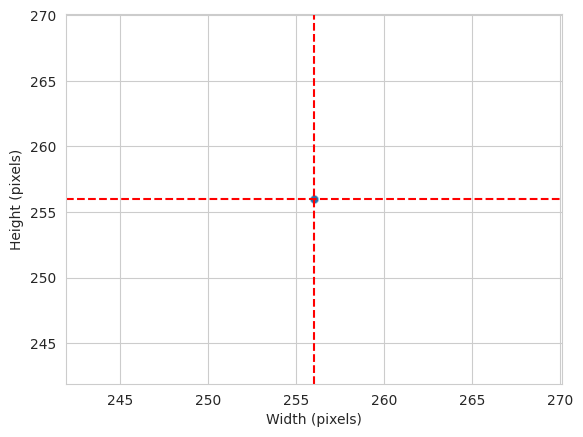

Width average: 256 
Height average: 256


In [12]:
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

Creating image_shape variable set as the standard image shape

In [14]:
image_shape = (dim1_mean, dim2_mean, 3)

* saving the average image shape/size with joblib as an pickle

In [16]:
joblib.dump(value=image_shape, filename=f"{file_path_one}/image_shape.pkl")

['output/v1/image_shape.pkl']

---

### load images using tensorflow
* loading all the images in an array
* creating an average image of all the images

---

loading images in an array

In [16]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

In [17]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)



Plot and save mean and variability of images per label

In [20]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array for a given label
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save the image
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path_one}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

==== Label healthy ====
Image Shape: (256, 256, 3)
==== Label powdery_mildew ====
Image Shape: (256, 256, 3)


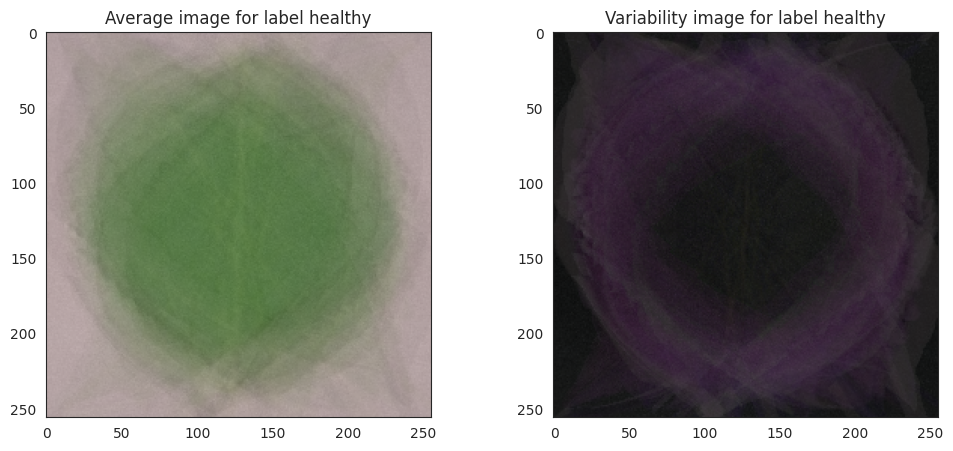

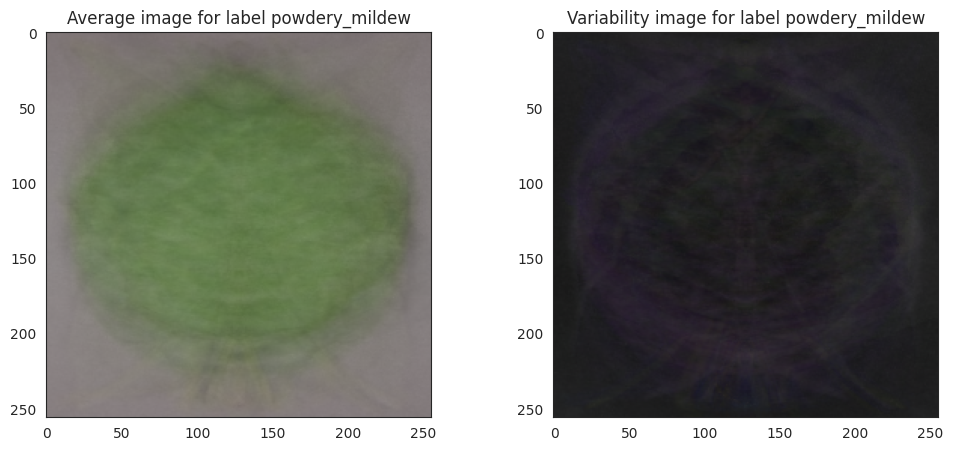

In [21]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)

---

## Doing the same but for the gray scale images

---

setting labels_gray for the gray scale images

In [26]:
labels_gray = os.listdir(train_path_gray)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


In [32]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(my_data_dir_gray, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir_gray)

    for label in labels_gray:
        counter = 0
        for image_filename in os.listdir(my_data_dir_gray + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir_gray + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

In [33]:
X, y = load_image_as_array(my_data_dir_gray=train_path_gray,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


* The same function used previous for the rgb images

In [34]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array for a given label
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save the image
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path_two}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

==== Label healthy-gray ====
Image Shape: (256, 256, 3)
==== Label powdery_mildew-gray ====
Image Shape: (256, 256, 3)


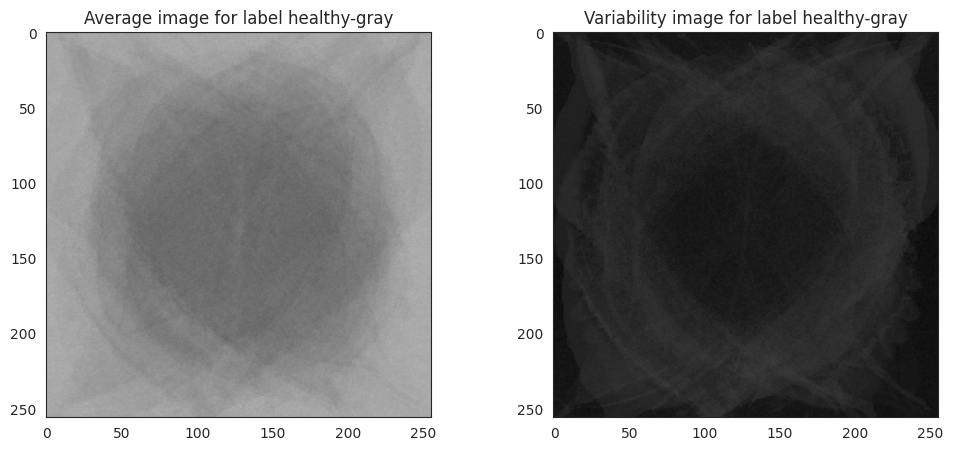

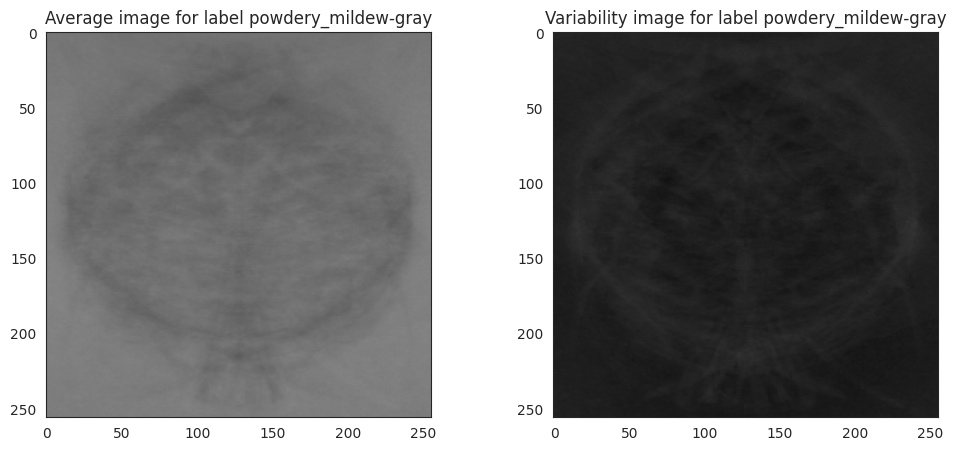

In [35]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)

# Push files to Repo